In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim

# 1. Dataset personalizado
class BreastImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
        # Crear mapeo clase -> índice
        self.classes = self.data['target_class'].unique().tolist()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['ruta_imagen']
        image = Image.open(img_path).convert('RGB')
        
        label_str = self.data.iloc[idx]['target_class']
        label = self.class_to_idx[label_str]
        
        if self.transform:
            image = self.transform(image)
        return image, label

# 2. Transformaciones para EfficientNet B0
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalización imagen preentrenada ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# 3. Cargar dataset y dividir train/test (80/20)
dataset = BreastImageDataset('dataset_augmented.csv', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 4. Modelo EfficientNet B0 con salida adaptada
num_classes = len(dataset.classes)
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_classes)  # cambiar capa final

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 5. Setup entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

# Función para entrenamiento
def train():
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Train Loss: {running_loss / len(train_loader):.4f}')

# Función para evaluación
def evaluate():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# 6. Loop principal
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train()
    evaluate()


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /Users/mafer/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


100.0%


Loaded pretrained weights for efficientnet-b0
Epoch 1/5
Train Loss: 0.6810
Test Accuracy: 57.53%
Epoch 2/5
Train Loss: 0.5041
Test Accuracy: 72.58%
Epoch 3/5
Train Loss: 0.4336
Test Accuracy: 64.52%
Epoch 4/5
Train Loss: 0.3516
Test Accuracy: 70.97%
Epoch 5/5
Train Loss: 0.2924
Test Accuracy: 75.27%


Test Accuracy: 72.58%


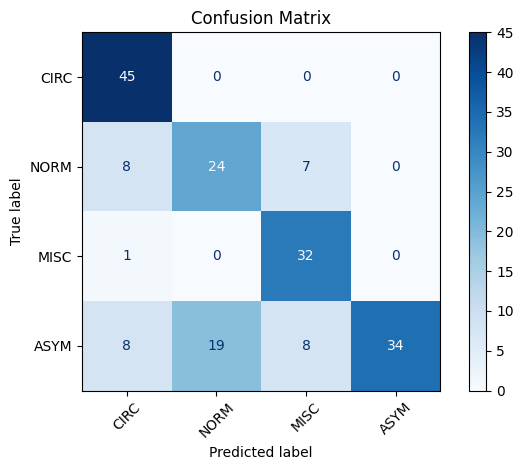

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate():
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


evaluate()